# Computing predicted occupancies, information content, and related metrics
This notebook takes all sequences in the libraries and computes the predicted occupancy of 8 TFs. Using those predicted occupancies, we then calculate the total occupancy, TF diversity, and information content (entropy) of each sequence.

In [1]:
import os
import sys

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display

sys.path.insert(0, "utils")
from utils import fasta_seq_parse_manip, modeling, plot_utils, predicted_occupancy, sequence_annotation_processing

data_dir = os.path.join("Data")
figures_dir = os.path.join("Figures")
all_seqs = fasta_seq_parse_manip.read_fasta(os.path.join(data_dir, "library1And2.fasta"))
# Drop scrambled sequences
all_seqs = all_seqs[~(all_seqs.index.str.contains("scr"))]

In [2]:
plot_utils.set_manuscript_params()

## Compute predicted occupancy of all TFs on all sequences

In [3]:
# Load in PWMs
pwms = predicted_occupancy.read_pwm_files(os.path.join("Data", "Downloaded", "Pwm", "photoreceptorAndEnrichedMotifs.meme"))
ewms = pwms.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)
mu = 9

# Do predicted occupancy scans
occupancy_df = predicted_occupancy.all_seq_total_occupancy(all_seqs, ewms, mu, convert_ewm=False)
occupancy_df = occupancy_df.rename(columns=lambda x: x.split("_")[0])
# Save to file
sequence_annotation_processing.save_df(occupancy_df, os.path.join(data_dir, "predictedOccupancies.txt"))

## Compute total occupancy, diversity, information content

In [4]:
entropy_df = occupancy_df.apply(predicted_occupancy.boltzmann_entropy, axis=1)
sequence_annotation_processing.save_df(entropy_df, os.path.join(data_dir, "entropyDiversityOccupancy.txt"))

## Plot predicted occupancy vs. relative $K_D$ for various values of $\mu$

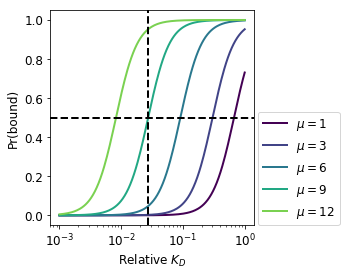

In [5]:
relative_kd = np.logspace(-3, 0, 200)
mu_values = [1, 3, 6, 9, 12]
mu_colors = plot_utils.set_color(np.arange(len(mu_values)) / len(mu_values))

width, height = mpl.rcParams["figure.figsize"]
fig, ax = plt.subplots(figsize=(width * 1.25, height))
for mu, color in zip(mu_values, mu_colors):
    occupancy_probability = 1.0 / (1 + np.exp(-2.5 * np.log(relative_kd) - mu))
    ax.semilogx(relative_kd, occupancy_probability, color=color, label=rf"$\mu = {mu}$")
    
ax.set_xlabel(r"Relative $K_D$")
ax.set_ylabel("Pr(bound)")
ax.legend(loc=(1.02, 0))

# Show where the 50% cutoff is for mu of 9
ax.axhline(0.5, color="k", linestyle="--")
ax.axvline(np.exp(9 / -2.5), color="k", linestyle="--")

plot_utils.save_fig(fig, os.path.join(figures_dir, "predictedOccupancyCurveVsMu"), timestamp=False)